In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import matplotlib.pyplot as plt
import os, torch, math, numpy as np


from load_data import create_dataloaders, CFG
from transform import make_simclr_transforms, SimCLRWrapperDataset, collate_two_views
from timesformer_min import TimeSformerEncoder
from pretrain_simclr import ProjectionHead, NTXentLoss  # reusing the exact defs

## pre-training (SimCLR)

In [2]:
# Build base loaders from Step 1 (labels ignored for SSL pretrain)
dl_train, dl_val, dl_test = create_dataloaders(CFG, batch_size=128, num_workers=4)

# Wrap the train dataset to produce two augmented views per clip
two_views = make_simclr_transforms()
ssl_ds = SimCLRWrapperDataset(dl_train.dataset, two_views)
ssl_loader = torch.utils.data.DataLoader(
    ssl_ds, batch_size=128, shuffle=True, num_workers=4, pin_memory=True,
    collate_fn=collate_two_views
)

device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

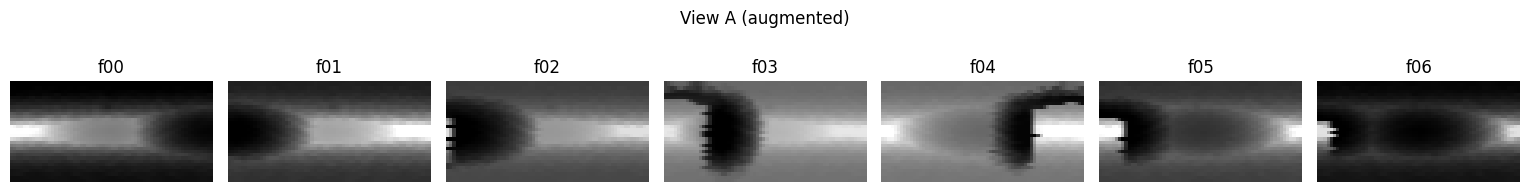

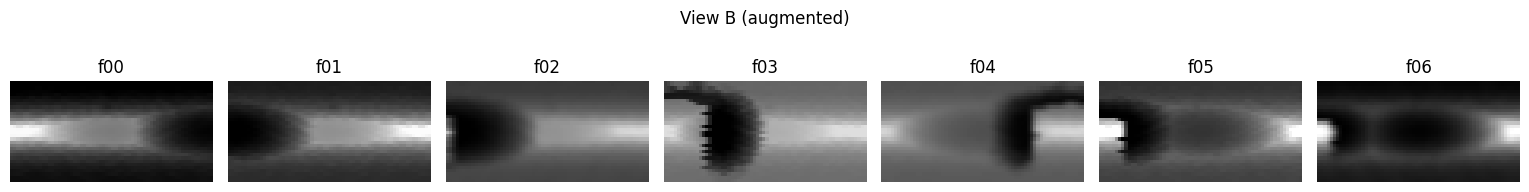

In [3]:
# Grab one batch and visualize a single sample's two views (7 frames each)
v1, v2 = next(iter(ssl_loader))   # v1,v2: [B,T,1,H,W] in [0,1]
idx = 0
clip1 = v1[idx].numpy()  # [T,1,H,W]
clip2 = v2[idx].numpy()

def show_clip(clip, title):
    T = clip.shape[0]
    fig, axes = plt.subplots(1, T, figsize=(T*2.2, 2.2))
    for t in range(T):
        axes[t].imshow(clip[t,0], cmap='gray', vmin=0, vmax=1)
        axes[t].set_axis_off()
        axes[t].set_title(f"f{t:02d}")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_clip(clip1, "View A (augmented)")
show_clip(clip2, "View B (augmented)")


In [4]:
import torch.nn as nn
import torch.nn.functional as F

class SimCLR(nn.Module):
    def __init__(self, encoder: nn.Module, proj_hidden=512, proj_out=128, temperature=0.1):
        super().__init__()
        self.encoder = encoder
        with torch.no_grad():
            dummy = torch.zeros(2, 7, 1, 32, 64)
            enc_dim = encoder(dummy).shape[-1]
        self.head = ProjectionHead(enc_dim, hidden=proj_hidden, out_dim=proj_out)
        self.criterion = NTXentLoss(temperature=temperature)

    def forward(self, v1, v2):
        h1 = self.encoder(v1)      # [B,D]
        h2 = self.encoder(v2)      # [B,D]
        z1 = self.head(h1)         # [B,d], L2-normalized
        z2 = self.head(h2)
        loss = self.criterion(z1, z2)
        return loss, (h1, h2), (z1, z2)

# instantiate encoder (sizes MUST match your data)
encoder = TimeSformerEncoder(
    in_ch=1, embed_dim=384, depth=6, num_heads=6,
    mlp_ratio=4.0, drop=0.1, attn_drop=0.0,
    patch=(8,8), T=7, H=32, W=64
)

model = SimCLR(encoder, proj_hidden=512, proj_out=128, temperature=0.1).to(device)

# Optimizer & scheduler
opt = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=5e-4)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=50)

scaler = torch.amp.GradScaler("cuda", enabled=(device=="cuda"))


In [5]:
from time import perf_counter

epochs = 30
batch_losses = []
epoch_losses = []

model.train()
for ep in range(1, epochs+1):
    t0 = perf_counter()
    running = 0.0
    n_batches = 0

    for v1, v2 in ssl_loader:
        v1 = v1.to(device, non_blocking=True)
        v2 = v2.to(device, non_blocking=True)

        opt.zero_grad(set_to_none=True)
        with torch.amp.autocast("cuda", enabled=(device=="cuda")):
            loss, *_ = model(v1, v2)

        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()

        running += float(loss.detach().cpu())
        batch_losses.append(float(loss.detach().cpu()))
        n_batches += 1

    sched.step()
    ep_loss = running / max(1, n_batches)
    epoch_losses.append(ep_loss)
    t1 = perf_counter()
    print(f"[SimCLR] epoch {ep:02d}  loss {ep_loss:.4f}  time {(t1-t0):.1f}s")


[SimCLR] epoch 01  loss 5.2010  time 62.2s
[SimCLR] epoch 02  loss 5.4637  time 62.7s
[SimCLR] epoch 03  loss 5.4636  time 61.1s
[SimCLR] epoch 04  loss 5.4623  time 61.0s
[SimCLR] epoch 05  loss 5.4424  time 61.3s
[SimCLR] epoch 06  loss 5.1058  time 61.1s
[SimCLR] epoch 07  loss 5.4623  time 61.2s
[SimCLR] epoch 08  loss 5.4609  time 61.1s
[SimCLR] epoch 09  loss 5.4504  time 60.9s
[SimCLR] epoch 10  loss 4.9557  time 61.1s
[SimCLR] epoch 11  loss 4.5956  time 61.1s
[SimCLR] epoch 12  loss 4.3242  time 61.2s
[SimCLR] epoch 13  loss 4.0007  time 61.3s
[SimCLR] epoch 14  loss 3.5490  time 61.3s
[SimCLR] epoch 15  loss 3.3456  time 61.1s
[SimCLR] epoch 16  loss 3.1254  time 61.0s
[SimCLR] epoch 17  loss 3.0862  time 61.2s
[SimCLR] epoch 18  loss 2.9502  time 60.9s
[SimCLR] epoch 19  loss 2.7783  time 61.0s
[SimCLR] epoch 20  loss 2.4955  time 61.0s
[SimCLR] epoch 21  loss 2.4946  time 61.3s
[SimCLR] epoch 22  loss 2.3456  time 62.9s
[SimCLR] epoch 23  loss 2.2484  time 61.1s
[SimCLR] ep

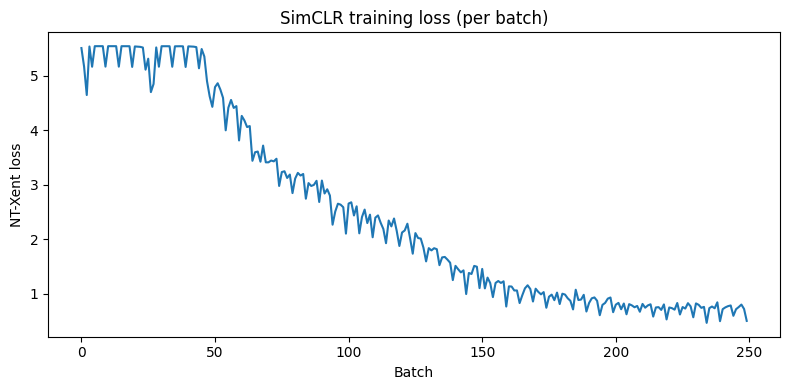

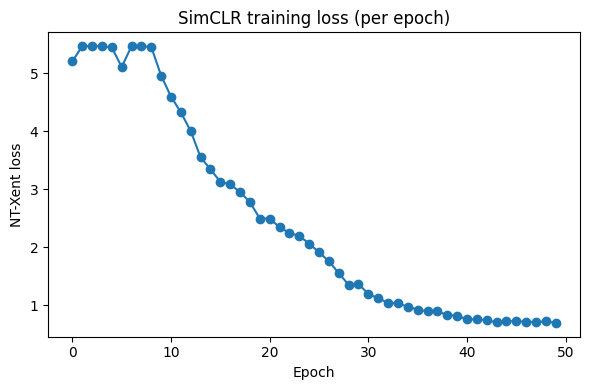

In [13]:
# Batch-wise loss (noisy but shows immediate trend)
plt.figure(figsize=(8,4))
plt.plot(batch_losses)
plt.title("SimCLR training loss (per batch)")
plt.xlabel("Batch")
plt.ylabel("NT-Xent loss")
plt.tight_layout()
plt.show()

# Epoch-wise loss (cleaner)
plt.figure(figsize=(6,4))
plt.plot(epoch_losses, marker='o')
plt.title("SimCLR training loss (per epoch)")
plt.xlabel("Epoch")
plt.ylabel("NT-Xent loss")
plt.tight_layout()
plt.show()


In [8]:
ckpt_path = r"C:\Users\shrua\OneDrive\Desktop\threshold project\threshold\models\timesformer_ssl_30.pth"
torch.save({
    "epoch": 30,
    "model_state": model.state_dict(),   # whole SimCLR (encoder + head)
    "optim_state": opt.state_dict(),
    "sched_state": sched.state_dict(),
}, ckpt_path)
ckpt_path


'C:\\Users\\shrua\\OneDrive\\Desktop\\threshold project\\threshold\\models\\timesformer_ssl_30.pth'

In [9]:
# rebuild the model & optimizer exactly the same way as before
encoder = TimeSformerEncoder(
    in_ch=1, embed_dim=384, depth=6, num_heads=6,
    mlp_ratio=4.0, drop=0.1, attn_drop=0.0,
    patch=(8,8), T=7, H=32, W=64
)

model = SimCLR(encoder, proj_hidden=512, proj_out=128, temperature=0.1).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=5e-4)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=50)

# load checkpoint
checkpoint = torch.load(ckpt_path, map_location=device)
model.load_state_dict(checkpoint["model_state"])
opt.load_state_dict(checkpoint["optim_state"])
sched.load_state_dict(checkpoint["sched_state"])
start_epoch = checkpoint["epoch"]   # 30

print(f"Resumed from epoch {start_epoch}")


Resumed from epoch 30


In [12]:
extra_epochs = 20
for ep in range(start_epoch + 1, start_epoch + extra_epochs + 1):
    t0 = perf_counter()
    running = 0.0
    n_batches = 0
    model.train()

    for v1, v2 in ssl_loader:
        v1 = v1.to(device, non_blocking=True)
        v2 = v2.to(device, non_blocking=True)

        opt.zero_grad(set_to_none=True)
        with torch.amp.autocast("cuda", enabled=(device == "cuda")):
            loss, *_ = model(v1, v2)

        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()

        loss_val = float(loss.detach().cpu())
        running += loss_val
        batch_losses.append(loss_val)   # keep per-batch history
        n_batches += 1

    sched.step()
    ep_loss = running / max(1, n_batches)
    epoch_losses.append(ep_loss)        # keep per-epoch history
    t1 = perf_counter()
    print(f"[SimCLR] epoch {ep:03d}  loss {ep_loss:.4f}  time {(t1 - t0):.1f}s")

    # save every few epochs
    if ep % 10 == 0:
        torch.save({
            "epoch": ep,
            "model_state": model.state_dict(),
            "optim_state": opt.state_dict(),
            "sched_state": sched.state_dict(),
        }, rf"C:\Users\shrua\OneDrive\Desktop\threshold project\threshold\models\timesformer_ssl_{ep}.pth")


[SimCLR] epoch 031  loss 1.1959  time 65.3s
[SimCLR] epoch 032  loss 1.1239  time 69.2s
[SimCLR] epoch 033  loss 1.0426  time 65.8s
[SimCLR] epoch 034  loss 1.0334  time 65.3s
[SimCLR] epoch 035  loss 0.9769  time 66.5s
[SimCLR] epoch 036  loss 0.9280  time 65.0s
[SimCLR] epoch 037  loss 0.8962  time 64.9s
[SimCLR] epoch 038  loss 0.9005  time 64.7s
[SimCLR] epoch 039  loss 0.8307  time 65.3s
[SimCLR] epoch 040  loss 0.8253  time 69.8s
[SimCLR] epoch 041  loss 0.7577  time 70.2s
[SimCLR] epoch 042  loss 0.7581  time 70.3s
[SimCLR] epoch 043  loss 0.7455  time 68.9s
[SimCLR] epoch 044  loss 0.7073  time 69.7s
[SimCLR] epoch 045  loss 0.7276  time 70.0s
[SimCLR] epoch 046  loss 0.7288  time 69.1s
[SimCLR] epoch 047  loss 0.7165  time 69.4s
[SimCLR] epoch 048  loss 0.7141  time 69.2s
[SimCLR] epoch 049  loss 0.7234  time 70.1s
[SimCLR] epoch 050  loss 0.6987  time 70.2s
